## Noisy Density Matrix Simulation

In [40]:
from jaqalpaq.parser import parse_jaqal_string
from jaqalpaq.emulator import run_jaqal_circuit
from jaqalpaq.core.result import parse_jaqal_output_list

In [41]:
simple_jaqal_circuit = parse_jaqal_string("""
from qscout.v1.std usepulses *

register q[2]

let pi 3.1415926535897932
let pi2 1.5707963267948966
let pi4 0.7853981633974483

loop 100 {
prepare_all
R q[0] 0 pi
measure_all
}

""")

In [42]:
# from qscout.v1.noisy import SNLToy1
from qscout.v1.ionsim import IonSimErrorModel
from qscout.v1.ion_interpolator import TargetOpFactory, adjust_time
# need to change "create opfactory method" of interpygate to make calls to
# self.TargetOpFactory, not __main__.TargetOpFacotry

In [70]:
# jaqal_result = run_jaqal_circuit(jaqal_circuit, backend=SNLToy1(2, depolarization=2e-3))
jaqal_result = run_jaqal_circuit(simple_jaqal_circuit, backend=IonSimErrorModel(2, time_stretch=2.5, sigmas=[1e-5, 0, 1e-9], sample=False))

phi/pi, theta/pi = 0.0 1.0
0 1e-05 (-0.001, 0.001, 5)
2.5 0 (1, 5, 5)
0 1e-09 (-1.2206020602060206e-08, 1.2206020602060206e-08, 5)
[[ 1.00000000e+00  1.90402282e-15  4.21333401e-16  9.29353070e-17]
 [-1.55775927e-06  9.99982919e-01  1.72502258e-07  6.26784617e-07]
 [ 9.63986687e-14 -1.72556760e-07 -7.28571377e-01  4.57050804e-01]
 [-5.38892938e-13  6.26794389e-07 -4.57051609e-01 -6.81626301e-01]]
phi/pi, theta/pi = 0.5 1.0
0 1e-05 (-0.001, 0.001, 5)
2.5 0 (1, 5, 5)
0 1e-09 (-1.2206020602060206e-08, 1.2206020602060206e-08, 5)
[[ 1.00000000e+00  6.63284582e-16  8.60200834e-16 -1.27350617e-16]
 [ 9.33566902e-14 -7.80831621e-01  1.61804436e-07  4.27928760e-01]
 [ 1.56113177e-06 -1.61760762e-07  9.99982895e-01 -6.50397477e-07]
 [-5.48258184e-13 -4.27929456e-01 -6.50415328e-07 -7.39503074e-01]]
phi/pi, theta/pi = 0.0 0.5
0 1e-05 (-0.001, 0.001, 5)
2.5 0 (1, 5, 5)
0 1e-09 (-1.2206020602060206e-08, 1.2206020602060206e-08, 5)
[[ 1.00000000e+00 -4.53243912e-16  3.87148768e-16 -2.23360955e-16]
 [

In [64]:
# [[ 1.00000000e+00  1.53060884e-15  1.40080786e-15 -4.56288785e-16]
#  [ 1.28127140e-08  9.99999788e-01  3.80208544e-10  2.86675476e-07]
#  [-2.28685992e-16 -4.93356737e-10 -9.99915229e-01  3.39112638e-03]
#  [ 1.33587278e-15  2.86674480e-07 -3.39112642e-03 -9.99915110e-01]]

In [71]:
jaqal_result

In [72]:
jaqal_result.subcircuits[0].probability_by_int

array([0.15918685, 0.84081315, 0.        , 0.        ])

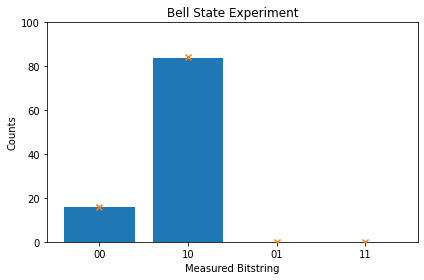

In [73]:
import matplotlib
from matplotlib import pyplot
from numpy import bincount

fig, ax = pyplot.subplots()
ax.set(ylim=(0,100))
data = [r.as_int for r in jaqal_result.subcircuits[0].readouts]
hist = bincount(data, None, 4)
probs = jaqal_result.subcircuits[0].probability_by_int
labels = [f"{n:02b}"[::-1] for n in range(4)]
ax.bar(range(4), height=hist, tick_label=labels)
ax.scatter(range(4), probs * 100, marker='x', zorder=3)
ax.set_xlabel('Measured Bitstring')
ax.set_ylabel('Counts')
ax.set_title('Bell State Experiment')
# ax.set_yscale('log')
fig.tight_layout()
pyplot.show()

## What is this object though?

In [8]:
con_model = SNLToy1(2, depolarization=2e-3)

NameError: name 'SNLToy1' is not defined

In [ ]:
con_model.__dict__.keys()

Parameters:

In [ ]:
con_model.depolarization, con_model.rotation_error, con_model.phase_error

A process matrix for every gate:

In [ ]:
con_model.model

A duration for every gate:

In [ ]:
con_model.gate_durations

The model and gate durations are all we actually need.

You can manually assemble them into with `CircuitEmulator`:

In [ ]:
from jaqalpaq.emulator.pygsti import CircuitEmulator

backend = CircuitEmulator(model=con_model.model, gate_durations=con_model.gate_durations)

In [ ]:
jaqal_result = run_jaqal_circuit(jaqal_circuit, backend=backend)

In [ ]:
fig, ax = pyplot.subplots()
ax.set(ylim=(0,10))
data = [r.as_int for r in jaqal_result.subcircuits[1].readouts]
hist = bincount(data, None, 4)
probs = jaqal_result.subcircuits[1].probability_by_int
labels = [f"{n:02b}"[::-1] for n in range(4)]
ax.bar(range(4), height=hist, tick_label=labels)
ax.scatter(range(4), probs * 10, marker='x', zorder=3)
ax.set_xlabel('Measured Bitstring')
ax.set_ylabel('Counts')
ax.set_title('Bell State Experiment')
fig.tight_layout()
pyplot.show()

## I want to make my own error model!

(Let's ignore crosstalk for now.)

You need:
 - A process matrix for every gate
 - A process matrix describing a qubit that is not being driven
 - The duration of the gates
 
 You could do this by hand, but we have a helper class to make this a little easier:

In [ ]:
# Useful tools:
from numpy import abs, diag, pi, kron
import pygsti

# Description of the ideal gates
from qscout.v1.native_gates import U_R, U_Rz, U_MS

# This superclass will handle some details
from jaqalpaq.emulator.pygsti import AbstractNoisyNativeEmulator

# The superclass needs a description of the gates to handle
from qscout.v1.native_gates import NATIVE_GATES


class MyToyEmulator(AbstractNoisyNativeEmulator):
    # This tells AbstractNoisyNativeEmulator what gate set we're modeling:
    jaqal_gates = NATIVE_GATES

    def __init__(self, *args, **kwargs):
        """Builds a MyCustomEmulator instance for particular parameters

        :param depolarization float: (default 1e-3) The depolarization during one
          pi/2 gate.
        :param rotation_error float: (default 1e-2) The over-rotation angle during one
          pi/2 gate.
        :param phase_error: (default 1e-2) The error in the x-y angle for (non-Z)
          rotation gates.
        """
        
        # Equivalent to
        # self.depolarization = kwargs.pop('depolarization', 1e-3 )
        # ...
        self.set_defaults(
            kwargs, depolarization=1e-3, rotation_error=1e-2, phase_error=1e-2
        )
        
        # Pass through the balance of the parameters to AbstractNoisyNativeEmulator
        # In particular: passes the number of qubits to emulated (in args)
        super().__init__(*args, **kwargs)

    # For every gate, we need to specify a superoperator and a duration:
    
    # pyGSTi has gate names that start with capital G
    # To avoid name clashes, we prepend our gates with J:    
    # GJR
    
    # We DO NOT currently support qubit-dependent error models (q will always be None)
    # Support for this is planned.  In the future, you will be able to write case
    # statements returning different process matrices for different qubits.
    def gateduration_R(self, q, axis_angle, rotation_angle):
        return abs(rotation_angle) / (pi / 2)

    def gate_R(self, q, axis_angle, rotation_angle):
        # We model the decoherence and over-rotation as a function of the gate duration:
        duration = self.gateduration_R(q, axis_angle, rotation_angle)

        # I.e., we scale the rotation and depolarization error by the time
        scaled_rotation_error = self.rotation_error * duration
        depolarization_term = (1 - self.depolarization) ** duration

        # Combine these all, returning a superoperator in the Pauli basis
        return pygsti.unitary_to_pauligate(
            U_R(axis_angle + self.phase_error, rotation_angle + scaled_rotation_error)
        ) @ diag([1, depolarization_term, depolarization_term, depolarization_term])

    # GJMS
    def gateduration_MS(self, q0, q1, axis_angle, rotation_angle):
        # Assume MS pi/2 gate 10 times longer than Sx, Sy, Sz
        return 10 * abs(rotation_angle) / (pi / 2)

    def gate_MS(self, q0, q1, axis_angle, rotation_angle):
        duration = self.gateduration_MS(q0, q1, axis_angle, rotation_angle)

        scaled_rotation_error = self.rotation_error * duration
        depolarization_term = (1 - self.depolarization) ** duration

        return pygsti.unitary_to_pauligate(
            U_MS(axis_angle + self.phase_error, rotation_angle + scaled_rotation_error)
        ) @ kron(diag([1] + 3*[depolarization_term]), diag([1] + 3*[depolarization_term]))

    
    # Rz is performed entirely in software.
    # GJRz
    def gateduration_Rz(self, q, angle):
        return 0

    def gate_Rz(self, q, angle):
        return pygsti.unitary_to_pauligate(U_Rz(angle))

    # A process matrix for the idle behavior of a qubit.
    # Gidle
    def idle(self, q, duration):
        depolarization_term = (1 - self.depolarization) ** duration

        return diag([1, depolarization_term, depolarization_term, depolarization_term])

    
    # We'll model the Rx gate as just an R gate with a particular axis_angle:
    
    # GJRx
    def gateduration_Rx(self, q, rotation_angle):
        # return self.gateduration_R(q, 0, rotation_angle)
        return abs(rotation_angle) / (pi / 2)

    def gate_Rx(self, q, rotation_angle):
        # return self.gate_R(q, 0, rotation_angle)
        duration = self.gateduration_Rx(q, rotation_angle)

        scaled_rotation_error = self.rotation_error * duration
        depolarization_term = (1 - self.depolarization) ** duration

        return pygsti.unitary_to_pauligate(
            U_R(0 + self.phase_error, rotation_angle + scaled_rotation_error)
        ) @ diag([1, depolarization_term, depolarization_term, depolarization_term])
    
    
    # We could do this for all the other gates, but that would be tedious.
    # Instead, we'll fill in the parameters with some syntactic sugar:

    # Instead of copy-pasting the above definitions, use _curry to create new methods
    # with some arguments.  None is a special argument that means: require an argument
    # in the created function and pass it through.
    C = AbstractNoisyNativeEmulator._curry

    # For reference:
    # def gate_R(self, q, axis_angle, rotation_angle):
    
    # GJRy ... etc
    gateduration_Ry, gate_Ry = C((None, pi / 2, None), gateduration_R, gate_R)
    gateduration_Px, gate_Px = C((None, 0.0, pi), gateduration_R, gate_R)
    gateduration_Py, gate_Py = C((None, pi / 2, pi), gateduration_R, gate_R)
    gateduration_Pz, gate_Pz = C((None, pi), gateduration_Rz, gate_Rz)
    gateduration_Sx, gate_Sx = C((None, 0.0, pi / 2), gateduration_R, gate_R)
    gateduration_Sy, gate_Sy = C((None, pi / 2, pi / 2), gateduration_R, gate_R)
    gateduration_Sz, gate_Sz = C((None, pi / 2), gateduration_Rz, gate_Rz)
    gateduration_Sxd, gate_Sxd = C((None, 0.0, -pi / 2), gateduration_R, gate_R)
    gateduration_Syd, gate_Syd = C((None, pi / 2, -pi / 2), gateduration_R, gate_R)
    gateduration_Szd, gate_Szd = C((None, -pi / 2), gateduration_Rz, gate_Rz)
    gateduration_Sxx, gate_Sxx = C((None, None, 0.0, pi / 2), gateduration_MS, gate_MS)

    del C

In [ ]:
backend = MyToyEmulator(2)

In [ ]:
jaqal_result = run_jaqal_circuit(jaqal_circuit, backend=backend)

In [ ]:
fig, ax = pyplot.subplots()
ax.set(ylim=(0,10))
data = [r.as_int for r in jaqal_result.subcircuits[1].readouts]
hist = bincount(data, None, 4)
probs = jaqal_result.subcircuits[1].probability_by_int
labels = [f"{n:02b}"[::-1] for n in range(4)]
ax.bar(range(4), height=hist, tick_label=labels)
ax.scatter(range(4), probs * 10, marker='x', zorder=3)
ax.set_xlabel('Measured Bitstring')
ax.set_ylabel('Counts')
ax.set_title('Bell State Experiment')
fig.tight_layout()
pyplot.show()

The minimal skeleton to use `AbstractNoisyNativeEmulator`

In [ ]:
from qscout.v1.native_gates import NATIVE_GATES
from jaqalpaq.emulator.pygsti import AbstractNoisyNativeEmulator

class YourCustomEmulator(AbstractNoisyNativeEmulator):
    jaqal_gates = NATIVE_GATES

    def __init__(self, *args, **kwargs):
        self.set_defaults(
            kwargs, #your custom parameters
        )
        super().__init__(*args, **kwargs)

    # GJR
    def gateduration_R(self, q, axis_angle, rotation_angle):
        return # your model's duration

    def gate_R(self, q, axis_angle, rotation_angle):
        return # your error model's superoperator in the Pauli basis
    
    # Gidle
    def idle(self, q, duration):
        return # your model's process matrix acting for the idle qubit
    
    # the rest of the gates